In [21]:
import json
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
ticker = 'BTC-USD'

In [23]:
with open(f"../{ticker}.json", "r") as file:
    data = json.load(file)
grpc, indexer = data["grpc"], data["indexer"]

In [24]:
def compute_cumulative_depth(orders, side='asks'):
    """
    Given a list of orders (each with keys "price" and "size"), compute
    the cumulative depth. Orders are sorted in ascending order by price for asks,
    descending for bids.
    """
    # Ensure price and size are floats (works for both gRPC (numbers) and Indexer (strings))
    orders = [{"price": float(o["price"]), "size": float(o["size"])} for o in orders]
    if side == "asks":
        orders = sorted(orders, key=lambda o: o["price"])
    elif side == "bids":
        orders = sorted(orders, key=lambda o: o["price"], reverse=True)

    px = []
    sz = []

    for o in orders:
        if len(px) > 0 and px[-1] == o['price']:
            sz[-1] += o["size"]
        else:
            px.append(o["price"])
            sz.append(o["size"])

    df = pd.DataFrame({"px": px, "sz": sz})
    df['ntl'] = df['px'] * df['sz']
    df['cum_ntl'] = df['ntl'].cumsum()
    return df

In [25]:
compute_cumulative_depth(indexer["bids"], side="bids").head()

,px,sz,ntl,cum_ntl
0,83857.0,0.1192,9995.7544,9995.7544
1,83856.0,0.0500,4192.8000,14188.5544
2,83855.0,1.5500,129975.2500,144163.8044
3,83854.0,0.0817,6850.8718,151014.6762
4,83853.0,0.0500,4192.6500,155207.3262


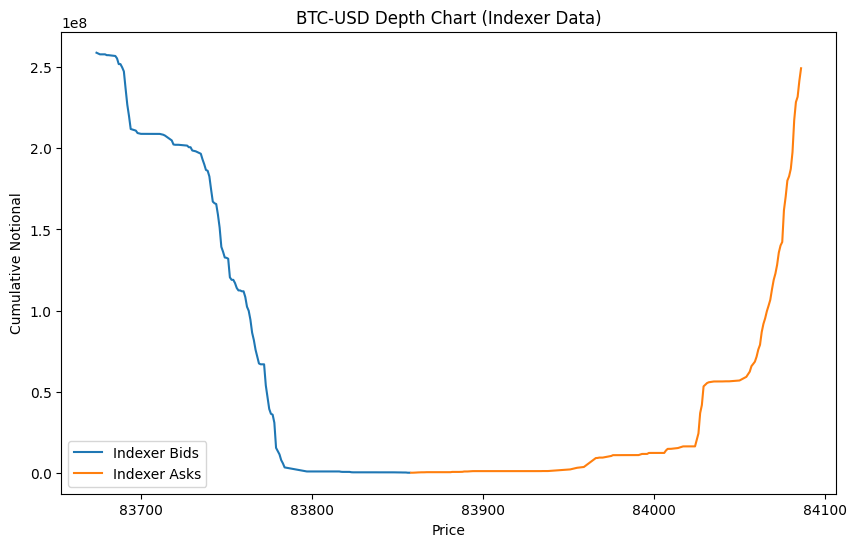

In [26]:
mid = (grpc["bids"][0]["price"] + grpc["asks"][0]["price"]) / 2
px_min, px_max = mid * 0.99, mid * 1.01

# Plot a depth chart for indexer data
ibids = compute_cumulative_depth(indexer["bids"], side="bids")
ibids = ibids[ibids['px'] >= px_min]
iasks = compute_cumulative_depth(indexer["asks"], side="asks")
iasks = iasks[iasks['px'] <= px_max]

plt.figure(figsize=(10, 6))
plt.plot(ibids['px'], ibids['cum_ntl'], label="Indexer Bids")
plt.plot(iasks['px'], iasks['cum_ntl'], label="Indexer Asks")

plt.xlabel("Price")
plt.ylabel("Cumulative Notional")
plt.title(f"{ticker} Depth Chart (Indexer Data)")

plt.legend()
plt.show()

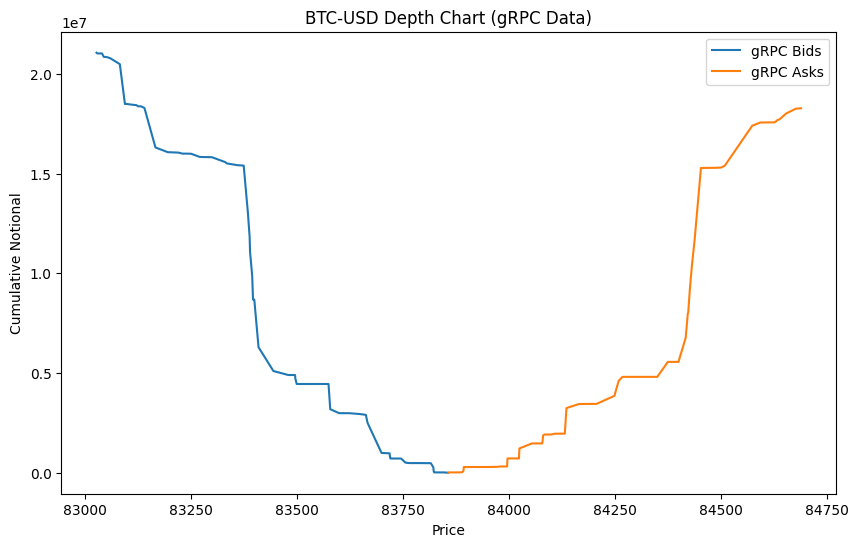

In [27]:
gbids = compute_cumulative_depth(grpc["bids"], side="bids")
gbids = gbids[gbids['px'] >= px_min]
gasks = compute_cumulative_depth(grpc["asks"], side="asks")
gasks = gasks[gasks['px'] <= px_max]

plt.figure(figsize=(10, 6))
plt.plot(gbids['px'], gbids['cum_ntl'], label="gRPC Bids")
plt.plot(gasks['px'], gasks['cum_ntl'], label="gRPC Asks")

plt.xlabel("Price")
plt.ylabel("Cumulative Notional")

plt.title(f"{ticker} Depth Chart (gRPC Data)")
plt.legend()
plt.show()

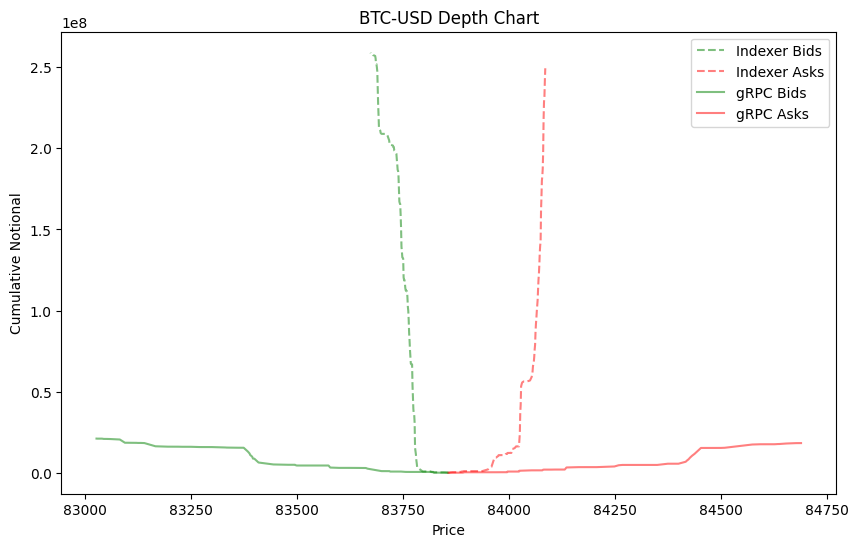

In [28]:
# Plot them on the same chart with log scale
plt.figure(figsize=(10, 6))

plt.plot(ibids['px'], ibids['cum_ntl'], label="Indexer Bids", color="green", linestyle="--", alpha=0.5)
plt.plot(iasks['px'], iasks['cum_ntl'], label="Indexer Asks", color="red", linestyle="--", alpha=0.5)
plt.plot(gbids['px'], gbids['cum_ntl'], label="gRPC Bids", color="green", alpha=0.5)
plt.plot(gasks['px'], gasks['cum_ntl'], label="gRPC Asks", color="red", alpha=0.5)

plt.xlabel("Price")
plt.ylabel("Cumulative Notional")
plt.title(f"{ticker} Depth Chart")

# plt.yscale("log")
plt.legend()
plt.show()

In [29]:
len(grpc['asks']), len(grpc['bids'])

(504, 633)

In [30]:
len(indexer['asks']), len(indexer['bids'])

(100, 100)